In [ ]:
!pip install box2d-py
!pip install stable-baselines3

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import pickle as pkl
import gym
import os

import torch as T
import torch.nn as nn

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.monitor import Monitor, load_results
from stable_baselines3.common.vec_env import VecFrameStack, VecNormalize, VecTransposeImage
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.type_aliases import ReplayBufferSamples
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3 import SAC

In [3]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
ENV_NAME = 'MountainCarContinuous-v0'
SAVE_DIR = 'gdrive/MyDrive/SQIL/Online/'
ONLINE_STEPS = 1e5    # 100,000 online environment steps
SEED = 1337

In [4]:
drive.mount('/content/gdrive/')  # model checkpoints + training stats 
set_random_seed(SEED)  # torch, np and py seeds

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

Mounted at /content/gdrive/


In [5]:
env = Monitor(gym.make(ENV_NAME), filename=SAVE_DIR+ENV_NAME)

checkpoint_callback = CheckpointCallback(
    save_freq=ONLINE_STEPS, 
    save_path=SAVE_DIR, 
    name_prefix=ENV_NAME
)

model = SAC(
    env=env,
    policy='MlpPolicy',
    learning_starts=0,
    learning_rate=3e-4,
    buffer_size=50000,
    batch_size=512,
    ent_coef=0.1,
    train_freq=32,
    gradient_steps=32,
    gamma=0.9999,
    tau=0.01,
    verbose=1,
    use_sde=True,
    policy_kwargs=dict(log_std_init=-3.67, net_arch=[64, 64])
)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [6]:
model.learn(ONLINE_STEPS, log_interval=10, callback=checkpoint_callback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 537      |
|    ep_rew_mean     | 61.3     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 55       |
|    time_elapsed    | 96       |
|    total timesteps | 5372     |
| train/             |          |
|    actor_loss      | -0.533   |
|    critic_loss     | 6.22     |
|    ent_coef        | 0.1      |
|    learning_rate   | 0.0003   |
|    n_updates       | 5344     |
|    std             | 0.0272   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 372      |
|    ep_rew_mean     | 75.1     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 55       |
|    time_elapsed    | 134      |
|    total timesteps | 7442     |
| train/             |          |
|    actor_loss      | -5.46    |
|    critic_loss     | 1.22     |
|    ent_coef 

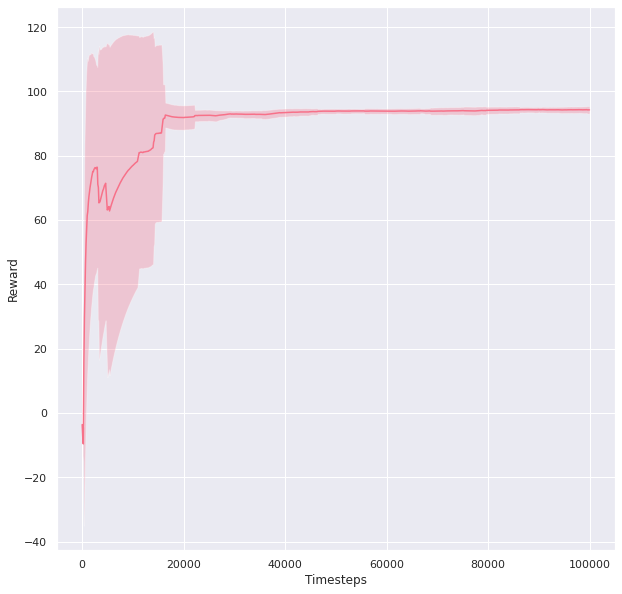

In [7]:
def plot_log(df_path):
    
    with open(df_path, "rt") as f:
        _ = f.readline()
        df = pd.read_csv(f)
        df.sort_values("t", inplace=True)
        df.reset_index(inplace=True)

    # compute rolling avg and std
    sma_y = df['r'].rolling(100, min_periods=1).mean()
    std_y = df['r'].rolling(100, min_periods=1).std()
    
    # plot with seaborn
    sns.set()
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Reward')
    clrs = sns.color_palette("husl", 8)

    true_x = (ONLINE_STEPS // max(df['index'])) * df['index']

    # fill standard deviation
    ax.plot(true_x, sma_y, c=clrs[0])
    ax.fill_between(true_x, sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    plt.savefig(SAVE_DIR+ENV_NAME+'.reward_history.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(SAVE_DIR+ENV_NAME+'.monitor.csv')

In [8]:
def get_expert_buf(num=100000):
    buf = {'observation':[], 'action':[], 'terminal':[], 'reward':[]}
    obs = env.reset()
    for _ in range(num):
        action, _states = model.predict(obs)
        buf['observation'].append(obs)
        buf['action'].append(action)
        obs, reward, done, info = env.step(action)
        buf['terminal'].append(done)
        buf['reward'].append(reward)
        if done:
            obs = env.reset()
    buf['observation'] = np.stack(buf['observation'])
    buf['action'] = np.stack(buf['action'])
    buf['reward'] = np.stack(buf['reward'])
    
    return buf

expert_data = get_expert_buf()
with open(SAVE_DIR+ENV_NAME+'.expert_data.pkl', 'wb') as f:
    pkl.dump(expert_data, f)